# 1. Setup and Load Data

## 1.1. Imports and config GPU usage

In [1]:
import os
import cv2
import imghdr
import itertools

import tensorflow_addons as tfa
import numpy as np 
import tensorflow as tf
import pandas as pd
import imgaug as ia

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras import layers
from tensorflow.python.client import device_lib
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator


from matplotlib import pyplot as plt
from imgaug import augmenters as iaa

c:\Users\Matheus Henrique\Repos_Pessoal\plant_pathology_classification\plant_disease_classification_env\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


## 1.2. Remove dodgy images

In [2]:
# # Setting the path to the directory containing datasets
# data_dir = '../datasets/train_test'

# # List of acceptable image extensions
# image_extensions = ['jpeg','jpg','bmp','png']

# # Looping through each dataset in the data directory
# for dataset in os.listdir(data_dir):
#     # Looping through each image in the current dataset
#     for image in os.listdir(os.path.join(data_dir, dataset)):
#         # Creating the path to the current image
#         image_path = os.path.join(data_dir, dataset, image)
        
#         try:
#             # Reading the image using OpenCV
#             img = cv2.imread(image_path)
#             # Checking the type of the image
#             tip = imghdr.what(image_path)

#             # If the image type is not in the list of acceptable image extensions
#             if tip not in image_extensions:
#                 # Printing a message indicating that the image is not in the list of extensions
#                 print('Image not in extensions list {}'.format(image_path))
#                 # Removing the image
#                 os.remove(image_path)
                
#         except Exception as e:
#             # Printing a message indicating there was an issue with the current image
#             print('Issue with image {}'.format(image_path))

## 1.3 Load data

In [3]:
train_data_dir = '../datasets/train_test/train_images/'
label_csv = '../datasets/train.csv'

# Read train.csv file
images_labels = pd.read_csv(label_csv)

In [4]:
# Encode competition-provided labels 
label_to_id = {
    'healthy': 0,
    'scab': 1,
    'frog_eye_leaf_spot': 2,
    'rust': 3,
    'complex': 4,
    'powdery_mildew': 5,
}

id_to_label = {value:key for key, value in label_to_id.items()} 

def parse_labels(row):
    label_list = row.split()
    labels = []
    for label in label_list:
        labels.append(str(label_to_id[label]))
    
    return ' '.join(labels)

images_labels['labels'] = images_labels['labels'].map(parse_labels)

In [5]:
# Helper functions
def make_path(row):
    return  os.path.join(train_data_dir, row.image)

# Get absolute path for images
images_labels['image'] = images_labels.apply(lambda row: make_path(row), axis=1)

# Look at the dataframe
images_labels.head()

image labels
0  ../datasets/train_test/train_images/800113bb65...      0
1  ../datasets/train_test/train_images/8002cb321f...  1 2 4
2  ../datasets/train_test/train_images/80070f7fb5...      1
3  ../datasets/train_test/train_images/8007751778...      1
4  ../datasets/train_test/train_images/800cbf0ff8...      4

In [6]:
# 6. Helper functions for input pipeline
def decode_image(image):
    # Convert the compressed string to a 3D uint8 tensor
    image = tf.image.decode_jpeg(image, channels=3)
    
    # Resize image
    image = tf.image.resize(image, (256, 256))

    # Normalize the image pixel values to the range [0, 1]
    image = tf.keras.applications.resnet.preprocess_input(image)


    return image

def load_image(data_dict):
    # Load image
    image = tf.io.read_file(data_dict['image'])
    image = decode_image(image)
    
    # Parse label
    labels = tf.strings.split(data_dict['labels'], sep=' ')
    labels = tf.strings.to_number(labels, out_type=tf.int32)
    one_hot_encoded_labels = tf.map_fn(lambda label: tf.one_hot(label, depth=len(label_to_id)), labels, dtype=tf.float32)
    one_hot_encoded_labels = tf.reduce_sum(one_hot_encoded_labels, axis=0)

    return image, one_hot_encoded_labels

# 7. Build data loaders
data_dict = dict(images_labels)
data = tf.data.Dataset.from_tensor_slices(data_dict)
data = data.map(load_image).batch(32) 
data_iterator = data.as_numpy_iterator()

Instructions for updating:
Use fn_output_signature instead


c:\Users\Matheus Henrique\Repos_Pessoal\plant_pathology_classification\plant_disease_classification_env\lib\site-packages\matplotlib\text.py:1241: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


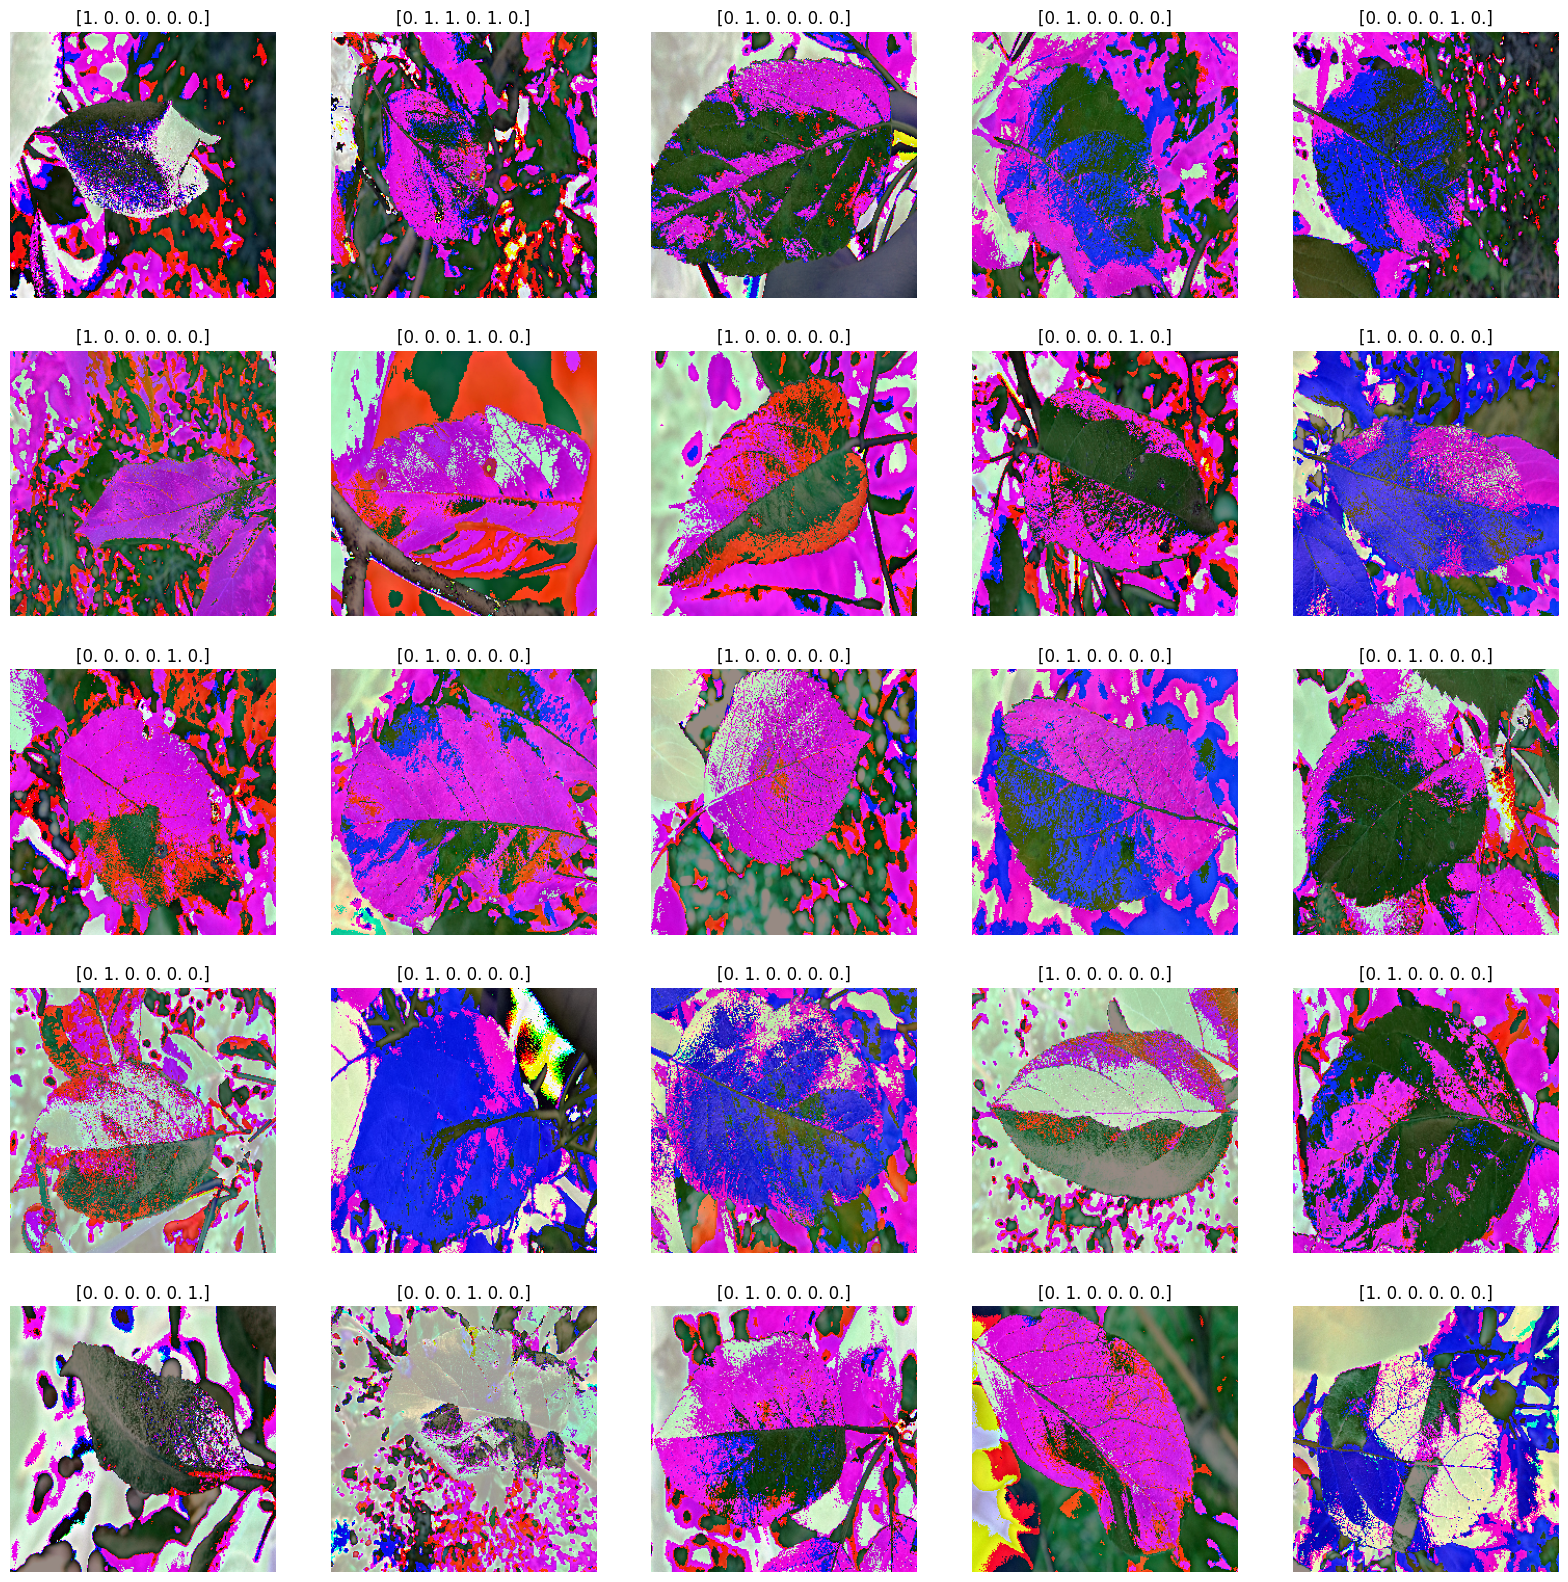

In [7]:
# Data loader sanity check
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(20,20))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n].astype(np.uint8))
        plt.title(label_batch[n])
        plt.axis('off')

image_batch, label_batch = data_iterator.next() #next(iter(data))
show_batch(image_batch, label_batch)

# 2.0. Preprocessing Data

## 2.1. Scale Data

In [8]:
data = data.map(lambda x, y: (x/255, y) )

## 2.2. Split Data

In [9]:
train_size = int(len(data)*0.7)
val_size = int(len(data)*0.2)
test_size = int(len(data)*0.1)

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [10]:
# Configurar o conjunto de dados para desempenho
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val.cache().prefetch(buffer_size=AUTOTUNE)

# 3.0. Deep Learning Model

## 3.1. Build CNN

In [11]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape=(256, 256, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

In [12]:
model = Sequential([
    data_augmentation,
    Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)),
    MaxPooling2D(),
    Conv2D(32, (3,3), 1, activation='relu'),
    MaxPooling2D(),
    Conv2D(16, (3,3), 1, activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(6, activation='sigmoid') 
])

In [13]:
model.compile('adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(multi_label=True), tfa.metrics.F1Score(num_classes=6, average='micro')])

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)       

## 3.2 Train

In [15]:
logdir = 'logs'
tensorboard_callbacks = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit( train, epochs=5, validation_data=val, callbacks=[tensorboard_callbacks])

Epoch 1/5
408/408 [==============================] - 1431s 3s/step - loss: 0.3763 - auc: 0.7758 - f1_score: 0.4646 - val_loss: 0.4015 - val_auc: 0.8322 - val_f1_score: 0.4898
Epoch 2/5
408/408 [==============================] - 1405s 3s/step - loss: 0.3039 - auc: 0.8698 - f1_score: 0.6085 - val_loss: 0.3672 - val_auc: 0.8615 - val_f1_score: 0.5647
Epoch 3/5
408/408 [==============================] - 1413s 3s/step - loss: 0.2694 - auc: 0.9005 - f1_score: 0.6586 - val_loss: 0.3229 - val_auc: 0.8876 - val_f1_score: 0.6233
Epoch 4/5
408/408 [==============================] - 1418s 3s/step - loss: 0.2522 - auc: 0.9137 - f1_score: 0.6846 - val_loss: 0.3047 - val_auc: 0.8986 - val_f1_score: 0.6318
Epoch 5/5
408/408 [==============================] - 1405s 3s/step - loss: 0.2373 - auc: 0.9248 - f1_score: 0.7070 - val_loss: 0.2672 - val_auc: 0.9115 - val_f1_score: 0.6783


## 3.3 Plot Performance

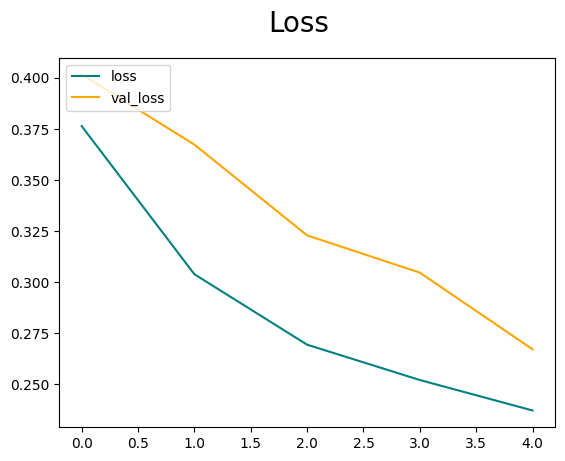

In [16]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

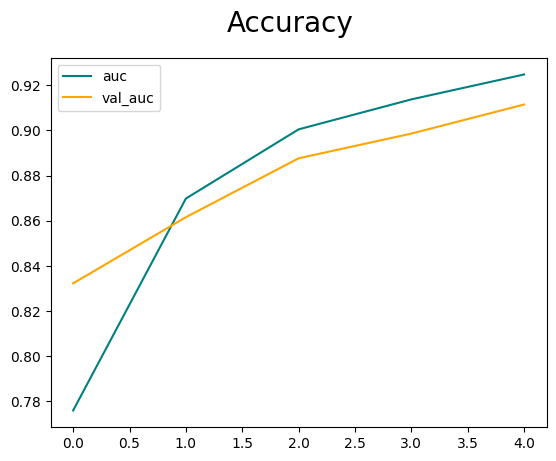

In [17]:
fig = plt.figure()
plt.plot(hist.history['auc'], color='teal', label='auc')
plt.plot(hist.history['val_auc'], color='orange', label='val_auc')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

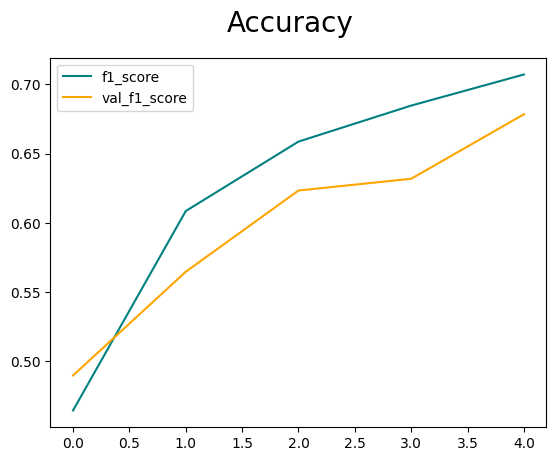

In [18]:
fig = plt.figure()
plt.plot(hist.history['f1_score'], color='teal', label='f1_score')
plt.plot(hist.history['val_f1_score'], color='orange', label='val_f1_score')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 4.0. Evaluate Performance

## 4.1. Evaluation Metrics

In [19]:
auc = tf.keras.metrics.AUC(multi_label=True)
f1 = tfa.metrics.F1Score(num_classes=6, average='micro')

In [20]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    auc.update_state(y, yhat)
    f1.update_state(y, yhat)

In [21]:
print(f'AUC: {auc.result().numpy()}, F1_SCORE: {f1.result().numpy()}')

AUC: 0.9124783873558044, F1_SCORE: 0.6808621883392334


In [22]:
readable_yhat = np.around(yhat, decimals=3)
readable_yhat[7]

array([0.825, 0.127, 0.   , 0.033, 0.001, 0.   ], dtype=float32)

# 5.0. Save the Model

In [23]:
model.save(os.path.join('models','plant_disease_classifier-v2.h5'))

In [ ]:
# model_loaded = load_model(os.path.join('models','plant_disease_classifier-v2.h5'))
# model_loaded.predict()